# **Intel Image Classification**

##Import the Dataset and Data Exploration

Firstly, we import all the useful libraries and packages.

In [ ]:
!pip install d2l==1.0.0a1.post0

In [ ]:
from pathlib import Path
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

import plotly.express as px
from d2l import torch as d2l

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We plot the distribution of the train dataset, in order to see if the classes are well-balanced.

In [ ]:
## we create our path to select the entire dataset on our Google Drive
root_path='/content/drive/MyDrive/Lavoro Deep Learning/Intel/seg_train'
## class_names is a list of all names of labels sorted in alphabetic order
class_names_original = sorted(os.listdir(root_path))
n_class_original=len(class_names_original) #number of classes
## class_dis is a list of all lengths of each labels
class_dis_original=[len(os.listdir(root_path + "/" + name)) for name in class_names_original]

In [ ]:
fig = px.bar(x = class_names_original, y = class_dis_original, color = class_names_original, text_auto='.3s') #create the histogram
fig.show() #show results

And then, we plot the distribution of the test.

In [ ]:
## we create our path to select the entire dataset on our Google Drive
root_path='/content/drive/MyDrive/Lavoro Deep Learning/Intel/seg_test'
## class_names is a list of all names of labels sorted in alphabetic order
class_names_original = sorted(os.listdir(root_path))
n_class_original=len(class_names_original) #number of classes
## class_dis is a list of all lengths of each labels
class_dis_original=[len(os.listdir(root_path + "/" + name)) for name in class_names_original]

In [ ]:
fig = px.bar(x = class_names_original, y = class_dis_original, color = class_names_original, text_auto='.3s') #create the histogram
fig.show() #show results

Looking at the two above bar plots, we can notice that the classes are well-balanced both in train and test dataset.

**Data augmentatation**: a set of techniques to increase the amount of data by generating new data point from existing data.

In [ ]:
transformation = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor()
    ])

train_dataset = torchvision.datasets.ImageFolder(
        root='/content/drive/MyDrive/Lavoro Deep Learning/Intel/seg_train',
        transform=transformation
    )

test_dataset = torchvision.datasets.ImageFolder(
        root='/content/drive/MyDrive/Lavoro Deep Learning/Intel/seg_test',
        transform=transformation
    )

In [ ]:
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=True
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=8,
        num_workers=2,
        shuffle=True
    )

In [ ]:
images, labels=next(iter(test_loader))

We provide some random examples of images of the dataset.

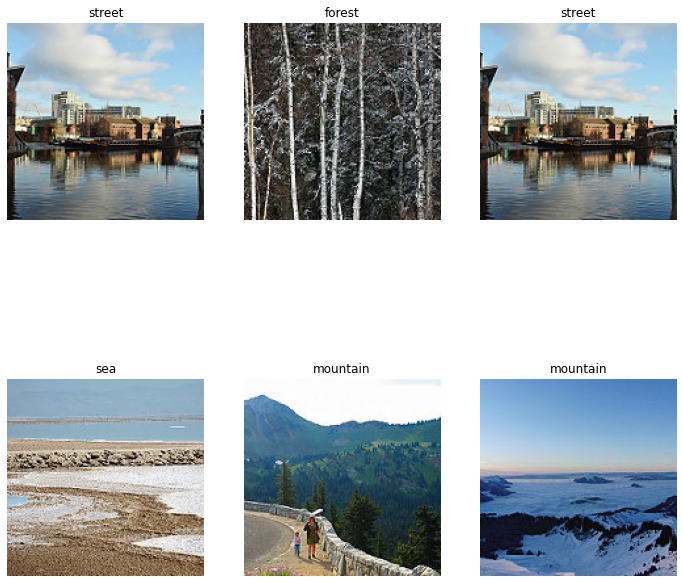

In [ ]:
classes = ('buildings', 'forest', 'glacier', 'mountain', 'sea','street')
#plot the images with the corresponding labels
fig,axes = plt.subplots(2,3,figsize=(12,12)) #we plot the images in 2 rows and 3 columnns, with a 12x12 size
for i in range(2): #two rows
    for j in range(3): #three columns
        plt.sca(axes[i,j])
        idx = np.random.randint(0,7) #take random images from a batch of size 8
        image = np.moveaxis(images[idx].numpy(),0,2)
        plt.title(classes[labels[idx].item()]) #show the label
        plt.imshow(image) #plot the image
        plt.axis('off')

## Model Implementation

We've decided to use **AlexNet**, which is one of the first convolutional neural network (CNN) that uses ReLU activation functions and dropouts regularization.

*Properties*:


*   It's a 8-layer CNN: five convolutional layer, followed by three fully-connected layers;
*   Start with a larger convolution window size (11x11);
-   Adopt the MaxPooling;




In [ ]:
net = nn.Sequential(
    # Use of a 11 x 11 window to capture objects.
    # Use of a stride of 4 to greatly reduce the height and width of the
    # output. Here, the number of output channels is much larger than that in
    # LeNet
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Convolution window smaller, set padding to 2 for consistent
    # height and width across the input and output
    # Increase of the number of output channels
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Use of three successive convolutional layers and a smaller convolution
    # window. Except for the final convolutional layer, the number of output
    # channels is further increased. Pooling layers are not used to reduce the
    # height and width of input after the first two convolutional layers
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # Below, a large number of outputs of the fully-connected layer.
    # Use the dropout layer to mitigate overfitting:
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # Output layer: the number of classes is 5
    nn.Linear(4096, 6))

Here, we define the function for training and accuracy evaluation phases

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Setting the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # Number of correct predictions, number of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required if doing the fine-tuning of BERT (recurrent network)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train(net, train_set, test_set, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # Xavier parameter initialization
    net.apply(init_weights)
    print('training on', device)

    net.to(device) # MOVE the net to the GPU
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_set)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train() # Set the network to training mode

        for i, (X, y) in enumerate(train_set):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) # MOVE each minibatch of data to the GPU
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad(): # detach gradient calculation for avoiding effects on backpropagation calculation
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()

            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_set)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.163, train acc 0.942, test acc 0.861
884.3 examples/sec on cuda:0


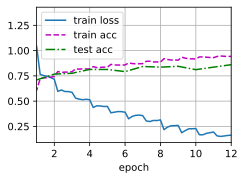

In [ ]:
lr, num_epochs = 0.01, 12
train(net, train_loader, test_loader, num_epochs, lr, device=d2l.try_gpu())


*Model's performance*:
*   **Train accuracy**: 94,2%
*   **Test accuracy**: 86,1%

Even if the two results are not the same, there is no evidence of overfitting.In fact, overfitting does not take place when your train accuracy is really high, it is when your train accuracy is high and your test accuracy is low.
Therefore, it is not abnormal that the train accuracy is higher than the test accuracy.

Another positive aspect regards the **train loss**, which is from the beggining very low.



Finally, in order to have a better visualization of our results, we build a confusion matrix.

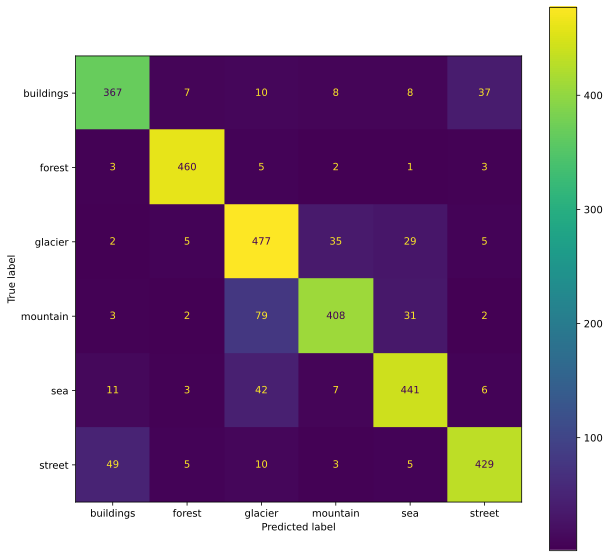

In [ ]:
y_pred = []
y_true = []
for inputs, labels in test_loader:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        inputs, labels = inputs.to(device), labels.to(device)
        output = net(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

classes = ('buildings', 'forest', 'glacier', 'mountain', 'sea','street')


cf_matrix = confusion_matrix(y_true, y_pred)
cmp=ConfusionMatrixDisplay(cf_matrix, display_labels=classes)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)
plt.show()

As we can see, we have a great performance among all the six classes.

## Conclusion
From our results, it's clear that the model has a good performance and well recognize images.